<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hands-On-1:-Sample-Big-Data-Set" data-toc-modified-id="Hands-On-1:-Sample-Big-Data-Set-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hands-On 1: Sample Big Data Set</a></span></li><li><span><a href="#Hands-On-2-3:-Constructing-a-User–Like-Matrix-and-trimming-it" data-toc-modified-id="Hands-On-2-3:-Constructing-a-User–Like-Matrix-and-trimming-it-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Hands-On 2-3: Constructing a User–Like Matrix and trimming it</a></span></li><li><span><a href="#Hands-On-4:-Reducing-the-Dimensionality-of-the-User–Like-Matrix-Using-SVD" data-toc-modified-id="Hands-On-4:-Reducing-the-Dimensionality-of-the-User–Like-Matrix-Using-SVD-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hands-On 4: Reducing the Dimensionality of the User–Like Matrix Using SVD</a></span></li><li><span><a href="#Hands-On-5:-Interpreting-Clusters-and-Dimensions" data-toc-modified-id="Hands-On-5:-Interpreting-Clusters-and-Dimensions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hands-On 5: Interpreting Clusters and Dimensions</a></span></li><li><span><a href="#Hands-On-6:-Predicting-Real-Life-Outcomes-With-Facebook-Likes" data-toc-modified-id="Hands-On-6:-Predicting-Real-Life-Outcomes-With-Facebook-Likes-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Hands-On 6: Predicting Real-Life Outcomes With Facebook Likes</a></span><ul class="toc-item"><li><span><a href="#Predicting-openness" data-toc-modified-id="Predicting-openness-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Predicting openness</a></span></li><li><span><a href="#Predicting-gender" data-toc-modified-id="Predicting-gender-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Predicting gender</a></span></li></ul></li></ul></div>

In [7]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np

import seaborn as sns

from sklearn.decomposition import FactorAnalysis, TruncatedSVD
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression

import scipy
from scipy import stats
from scipy.sparse import lil_matrix, csr_matrix, coo_matrix, hstack
from scipy.linalg import svd
from scipy.sparse.linalg import svds

import statistics
import math
from tqdm import tqdm

# Hands-On 1: Sample Big Data Set

In [14]:
user_df = pd.read_csv('../../ipa_data/project 10/users.csv')
likes_df = pd.read_csv('../../ipa_data/project 10/likes.csv')
users_likes_df = pd.read_csv('../../ipa_data/project 10/users-likes.csv')
users_likes_df["count"] = 1
user_df.shape, likes_df.shape, users_likes_df.shape

((110728, 9), (1580284, 2), (10612326, 3))

# Hands-On 2-3: Constructing a User–Like Matrix and trimming it

In [15]:
#https://stackoverflow.com/questions/31661604/efficiently-create-sparse-pivot-tables-in-pandas
person_c = CategoricalDtype(sorted(users_likes_df.userid.unique()), ordered=True)
thing_c = CategoricalDtype(sorted(users_likes_df.likeid.unique()), ordered=True)

row = users_likes_df.userid.astype(person_c).cat.codes
col = users_likes_df.likeid.astype(thing_c).cat.codes

sparse_matrix = csr_matrix((users_likes_df["count"], (row, col)), \
                           shape=(person_c.categories.size, thing_c.categories.size))

users = person_c.categories
likes = thing_c.categories

i = 0
counter = 0
while (sum(sparse_matrix.shape)!= i):    
    counter += 1
    i = sum(sparse_matrix.shape)
    rows_bool=np.squeeze(np.array(np.sum(sparse_matrix, axis = 1)) >= 50)
    rows_index = np.nonzero(rows_bool)[0]
    cols_bool = np.squeeze(np.array(np.sum(sparse_matrix, axis = 0)) >= 150)
    cols_index = np.nonzero(cols_bool)[0]
    users = users[rows_bool]
    likes = likes[cols_bool]
    sparse_matrix = sparse_matrix[rows_index,:]
    sparse_matrix = sparse_matrix[:,cols_index]

userlikes = pd.DataFrame(sparse_matrix.toarray(), index = users, columns = likes)
userlikes

0001a993cf6b165ab09c448452a4b640  \
00035a29fa913610d9dfd1c6d6a15fd6                                 0   
000769fb960a5900187f6631c4bb7264                                 0   
00082a96ca78b2883a3e24b9e8823567                                 0   
000bd7a4a05b867dca40edbfc37e474f                                 0   
00217ff065b47f79902cb8b57b897608                                 0   
...                                                            ...   
fffd7cce7529dad7d2514bec9389699e                                 0   
fffd881a692a2b79d4af5745fa9df0e5                                 0   
fffe2db87535e0c9e634399a37d672ad                                 0   
fffeb7527d47713e9cb909cc0907deea                                 0   
ffffa3400ccdaa16ebaa0244ce2f7751                                 0   

                                  00178dc9c063a70097e686da3bf5a185  \
00035a29fa913610d9dfd1c6d6a15fd6                                 0   
000769fb960a5900187f6631c4bb7264                                 0   
00082a96ca78b2883a3e24b9e8823567                                 0   
000bd7a4a05b867dca40edbfc37e474f                                 1   
00217ff065b47f79902cb8b57b897608                                 0   
...                                                            ...   
fffd7cce7529dad7d2514bec9389699e                                 0   
fffd881a692a2b79d4af5745fa9df0e5                                 0   
fffe2db87535e0c9e634399a37d672ad                                 0   
fffeb7527d47713e9cb909cc0907deea                                 0   
ffffa3400ccdaa16ebaa0244ce2f7751                                 0   

                                  001d60059e081f6a70dda1f33ba43c75  \
00035a29fa913610d9dfd1c6d6a15fd6                                 0   
000769fb960a5900187f6631c4bb7264                                 0   
00082a96ca78b2883a3e24b9e8823567                                 0   
000bd7a4a05b867dca40edbfc37e474f                                 0   
00217ff065b47f79902cb8b57b897608                                 0   
...                                                            ...   
fffd7cce7529dad7d2514bec9389699e                                 0   
fffd881a692a2b79d4af5745fa9df0e5                                 0   
fffe2db87535e0c9e634399a37d672ad                                 0   
fffeb7527d47713e9cb909cc0907deea                                 0   
ffffa3400ccdaa16ebaa0244ce2f7751                                 0   

                                  001f03652ca11ffa34941c32b1697750  \
00035a29fa913610d9dfd1c6d6a15fd6                                 0   
000769fb960a5900187f6631c4bb7264                                 0   
00082a96ca78b2883a3e24b9e8823567                                 0   
000bd7a4a05b867dca40edbfc37e474f                                 0   
00217ff065b47f79902cb8b57b897608                                 0   
...                                                            ...   
fffd7cce7529dad7d2514bec9389699e                                 0   
fffd881a692a2b79d4af5745fa9df0e5                                 0   
fffe2db87535e0c9e634399a37d672ad                                 0   
fffeb7527d47713e9cb909cc0907deea                                 0   
ffffa3400ccdaa16ebaa0244ce2f7751                                 0   

                                  00202926ec450f94d5f21ac34a2761db  \
00035a29fa913610d9dfd1c6d6a15fd6                                 0   
000769fb960a5900187f6631c4bb7264                                 0   
00082a96ca78b2883a3e24b9e8823567                                 0   
000bd7a4a05b867dca40edbfc37e474f                                 0   
00217ff065b47f79902cb8b57b897608                                 0   
...                                                            ...   
fffd7cce7529dad7d2514bec9389699e                                 0   
fffd881a692a2b79d4af5745fa9df0e5                                 0   
fffe2db87535e0c9e634399a37d672ad        

# Hands-On 4: Reducing the Dimensionality of the User–Like Matrix Using SVD

In [16]:
svd = TruncatedSVD(n_components = 50)
results = svd.fit_transform(userlikes)
results = FactorAnalysis(rotation='varimax', n_components=50).fit_transform(results)
u_rot = pd.DataFrame(results, columns = [f'{i}' for i in range(1, 51)])
u_rot["userid"] = users
u_rot

1         2         3         4         5         6         7  \
0      1.574932  2.848711 -0.723478  0.436371  0.720050 -0.162906 -0.126614   
1     -0.366776 -0.298136 -0.670753  0.105502  0.160800  0.373041  0.064893   
2      1.375285  1.421951 -2.979209  0.224899  0.263654  0.337182 -0.368240   
3      0.239565 -0.040894 -1.629363  0.471329 -0.480780  0.451914 -0.545493   
4     -0.542737 -0.193357  0.211909  0.622519  0.394321  0.417470  0.310087   
...         ...       ...       ...       ...       ...       ...       ...   
19737 -0.513900 -0.479289 -0.364771  0.444694 -0.035104  0.035431 -0.247353   
19738 -0.622151 -0.333207  0.182732 -0.588935 -0.227814  0.281527  0.064050   
19739 -0.440922  0.162375  0.835093  0.064253  0.082184  0.053527 -0.121326   
19740 -0.282610  0.153717  0.091247  0.016912 -0.061757 -0.668449  0.060664   
19741 -0.627906 -0.387303  0.087156  0.338087  0.296212  0.362692  0.157176   

              8         9        10  ...   42   43   44   45   46   47   48  \
0     -0.419035 -0.140988  0.335244  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.110047  0.175795  0.068246  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     -0.051251  0.392678  0.170314  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      0.357022  0.015808  0.084159  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     -0.134104 -0.075103  0.032096  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
19737 -0.036333 -0.050826 -0.175163  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
19738  0.043232 -0.098136  0.046556  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
19739 -0.098913  0.213908 -0.134366  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
19740  0.125331 -0.074097 -0.126999  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
19741 -0.090082  0.062019  0.063690  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

        49   50                            userid  
0      0.0  0.0  00035a29fa913610d9dfd1c6d6a15fd6  
1      0.0  0.0  000769fb960a5900187f6631c4bb7264  
2      0.0  0.0  00082a96ca78b2883a3e24b9e8823567  
3      0.0  0.0  000bd7a4a05b867dca40edbfc37e474f  
4      0.0  0.0  00217ff065b47f79902cb8b57b897608  
...    ...  ...                               ...  
19737  0.0  0.0  fffd7cce7529dad7d2514bec9389699e  
19738  0.0  0.0  fffd881a692a2b79d4af5745fa9df0e5  
19739  0.0  0.0  fffe2db87535e0c9e634399a37d672ad  
19740  0.0  0.0  fffeb7527d47713e9cb909cc0907deea  
19741  0.0  0.0  ffffa3400ccdaa16ebaa0244ce2f7751  

[19742 rows x 51 columns]

In [46]:
userlikes.shape

(19742, 8523)

In [50]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(np.array(userlikes), 
                              n_components=5,
                              n_iter=5,
                              random_state=None)
v_rot = FactorAnalysis(rotation='varimax', n_components=5).fit_transform(VT.T)


In [54]:
v_rot_df = pd.DataFrame(v_rot, index = likes, columns = ["1", "2", "3", "4", "5"])

In [17]:
u_merged = u_rot.merge(user_df, left_on = "userid", right_on = "userid", how = "left")
u_merged.index = u_rot["userid"]
u_merged.drop(["userid"], axis = 1, inplace=True)
u_merged

1         2         3         4  \
userid                                                                     
00035a29fa913610d9dfd1c6d6a15fd6  1.574932  2.848711 -0.723478  0.436371   
000769fb960a5900187f6631c4bb7264 -0.366776 -0.298136 -0.670753  0.105502   
00082a96ca78b2883a3e24b9e8823567  1.375285  1.421951 -2.979209  0.224899   
000bd7a4a05b867dca40edbfc37e474f  0.239565 -0.040894 -1.629363  0.471329   
00217ff065b47f79902cb8b57b897608 -0.542737 -0.193357  0.211909  0.622519   
...                                    ...       ...       ...       ...   
fffd7cce7529dad7d2514bec9389699e -0.513900 -0.479289 -0.364771  0.444694   
fffd881a692a2b79d4af5745fa9df0e5 -0.622151 -0.333207  0.182732 -0.588935   
fffe2db87535e0c9e634399a37d672ad -0.440922  0.162375  0.835093  0.064253   
fffeb7527d47713e9cb909cc0907deea -0.282610  0.153717  0.091247  0.016912   
ffffa3400ccdaa16ebaa0244ce2f7751 -0.627906 -0.387303  0.087156  0.338087   

                                         5         6         7         8  \
userid                                                                     
00035a29fa913610d9dfd1c6d6a15fd6  0.720050 -0.162906 -0.126614 -0.419035   
000769fb960a5900187f6631c4bb7264  0.160800  0.373041  0.064893  0.110047   
00082a96ca78b2883a3e24b9e8823567  0.263654  0.337182 -0.368240 -0.051251   
000bd7a4a05b867dca40edbfc37e474f -0.480780  0.451914 -0.545493  0.357022   
00217ff065b47f79902cb8b57b897608  0.394321  0.417470  0.310087 -0.134104   
...                                    ...       ...       ...       ...   
fffd7cce7529dad7d2514bec9389699e -0.035104  0.035431 -0.247353 -0.036333   
fffd881a692a2b79d4af5745fa9df0e5 -0.227814  0.281527  0.064050  0.043232   
fffe2db87535e0c9e634399a37d672ad  0.082184  0.053527 -0.121326 -0.098913   
fffeb7527d47713e9cb909cc0907deea -0.061757 -0.668449  0.060664  0.125331   
ffffa3400ccdaa16ebaa0244ce2f7751  0.296212  0.362692  0.157176 -0.090082   

                                         9        10  ...   49   50  gender  \
userid                                                ...                     
00035a29fa913610d9dfd1c6d6a15fd6 -0.140988  0.335244  ...  0.0  0.0       1   
000769fb960a5900187f6631c4bb7264  0.175795  0.068246  ...  0.0  0.0       0   
00082a96ca78b2883a3e24b9e8823567  0.392678  0.170314  ...  0.0  0.0       1   
000bd7a4a05b867dca40edbfc37e474f  0.015808  0.084159  ...  0.0  0.0       1   
00217ff065b47f79902cb8b57b897608 -0.075103  0.032096  ...  0.0  0.0       1   
...                                    ...       ...  ...  ...  ...     ...   
fffd7cce7529dad7d2514bec9389699e -0.050826 -0.175163  ...  0.0  0.0       1   
fffd881a692a2b79d4af5745fa9df0e5 -0.098136  0.046556  ...  0.0  0.0       1   
fffe2db87535e0c9e634399a37d672ad  0.213908 -0.134366  ...  0.0  0.0       0   
fffeb7527d47713e9cb909cc0907deea -0.074097 -0.126999  ...  0.0  0.0       0   
ffffa3400ccdaa16ebaa0244ce2f7751  0.062019  0.063690  ...  0.0  0.0       1   

                                  age  political   ope   con   ext   agr   neu  
userid                                                                          
00035a29fa913610d9dfd1c6d6a15fd6   23        NaN  0.70  1.36 -0.27 -0.59 -0.88  
000769fb960a5900187f6631c4bb7264   25        NaN -3.37 -1.38 -0.46 -1.59  1.30  
00082a96ca78b2883a3e24b9e8823567   20        NaN -1.70  0.25 -0.89 -0.51 -0.01  
000bd7a4a05b867dca40edbfc37e474f   24        NaN -0.87  0.69  0.86  0.82 -0.70  
00217ff065b47f79902cb8b57b897608   25        1.0  0.15  0.39 -2.08 -0.93  2.42  
...                               ...        ...   ...   ...   ...   ...   ...  
fffd7cce7529dad7d2514bec9389699e   22        0.0  0.42  0.39 -0.52 -1.76  0.11  
fffd881a692a2b79d4af5745fa9df0e5   26        NaN  1.35 -0.23  0.36  1.90 -0.45  
fffe2db87535e0c9e634399a37d672ad   26        NaN  0.33 -0.12 -0.12  0.07  0.23  
fffeb7527d47713e9cb909cc0907deea   27        NaN  0.70  1.43 -1.27  1.09 -1.01  
ffffa3400ccdaa16ebaa0244ce2f7751   26        0.0  0.24  1.70  0

# Hands-On 5: Interpreting Clusters and Dimensions

<AxesSubplot:>

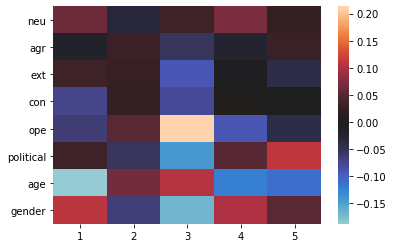

In [26]:
users_u = u_merged[["1", "2", "3", "4", "5"]]
users_d = u_merged[["gender", "age", "political", "ope", "con", "ext", "agr", "neu"]]

df = pd.DataFrame()
for i in ["1", "2", "3", "4", "5"]:
    df[i] = users_d.corrwith(users_u[i])

sns.heatmap(data=df.iloc[::-1], center = 0)

In [74]:
likes_df.index = likes_df["likeid"]

In [78]:
#find 
strongest = []
users_u_sort = v_rot_df.copy().reset_index()
for i in ["1", "2", "3", "4", "5"]:
    f = (v_rot_df).sort_values(by = i, ascending = 0).index
    temp = list(f[0:10])
    strongest.append(likes_df.loc[temp]["name"])
    

Strongest associated likes for 1-5 from R code:


 "Nicki Minaj"   "The Boondocks" "Bob Marley"    "Trey Songz"    "Eminem"        "Family Guy"    "Drake"        
"The Hangover"  "T.I."          "Lil Wayne"    


"Music"        "Reese's"      "Starbucks"    "Adam Sandler" "Disney"       "Starburst"    "Oreo"         "Facebook"    
"Skittles"     "YouTube"     


"The Beatles"           "Green Day"             "Pink Floyd"            "System of a Down"      "Red Hot Chili Peppers"
"Nirvana"               "Disturbed"             "Metallica"             "Family Guy"            "Linkin Park"          


"Lil Wayne"        "Taylor Swift"     "Twilight"         "Avril Lavigne"    "Nickelback"       "3OH!3"           
"Three Days Grace" "Paramore"         "Eminem"           "Linkin Park"     


"Homemade Chocolate Chip Cookies" "Yelling at inanimate objects"    "Brownies"                       
"Staying Up Late"                 "bubblewrap"                      "Spinny Chairs"                  
"Cookie Dough"                    "Music"                           "I love staying up late!"        
"Finding Money In Your Pocket"   

In [79]:
strongest

[likeid
 17600c4bfc5934bd9fcbe440425299e3        Skittles
 f44cf13279f767a8e34259d8fb024202       Starburst
 39da88448325579b5eb55e4ae933046e         YouTube
 a38d5554ffe0d60b3c7aac176af9e29a            Oreo
 1e40428dc7c2d767df5d749256361d62        Facebook
 d6b45ff7ef33f103ec222e9c8866e107          Disney
 a945282c66aaf1e2be81073cff84e9a8      Katy Perry
 34fbfcf1fca34d3733d08b4eb06619ee    Adam Sandler
 12c554c07c8ea38fcca49cd0f612df5a       Coca-Cola
 46ad8d0c13e78b806016b7284a5d53c3       Starbucks
 Name: name, dtype: object,
 likeid
 5805c962b769d02525c453065f915849            Linkin Park
 23b5f4877deb9f684d3ccae5311384ed               Paramore
 6ba590d8f1791a668a020d065d442c21              Green Day
 10d8fd16d06ca8b4e38d525eec460e6d      Breaking Benjamin
 ff0f53f2e61b98927968245aa10e2d02           Fall Out Boy
 3849b653ea1d838b4fbe09dd09ed273a             Nickelback
 c55e46227671a8033b15406ad30b079e    My Chemical Romance
 9a465db53d870c06e8a197ee1e37483b            Evanescence


# Hands-On 6: Predicting Real-Life Outcomes With Facebook Likes

## Predicting openness

In [50]:
def predict_using_linear_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    return y_pred, y_test

def corr_score(y_true,y_pred):
    return stats.pearsonr(y_true,y_pred)[0]

corr_scorer = make_scorer(corr_score, greater_is_better=True)

In [51]:
u_rot = u_merged[[f'{i}' for i in range(1, 51)]]
openess = u_merged['ope']
gender = u_merged['gender']

X = u_rot.iloc[:, :50]
y_o = openess

In [55]:
y_pred, y_test = predict_using_linear_regression(X, y_o)
corr_score(y_test,y_pred)

0.4198693633368976

<AxesSubplot:xlabel='dim', ylabel='acc'>

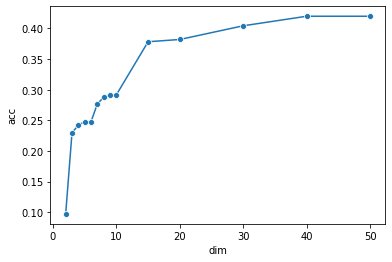

In [63]:
accs = pd.DataFrame(columns=['dim', 'acc'])
for i, dim in enumerate([*range(2, 10), 10, 15, 20, 30, 40, 50]):
    X_short = u_rot.iloc[:, :dim]
    y_pred, y_test = predict_using_linear_regression(X_short, y_o)
    acc = corr_score(y_test,y_pred)
    accs.loc[i] = [dim, acc]
sns.lineplot(data=accs, y='acc', x='dim', marker='o')

In [59]:
statistics.mean(cross_val_score(LinearRegression(), X, y_o, cv=10, scoring=corr_scorer))

0.4250678353899998

## Predicting gender

In [60]:
y_g = gender
X_train, X_test, y_train, y_test = train_test_split(X, y_g, test_size=0.2, random_state=0)
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
y_pred = clf.predict(X_test)
roc_auc_score(y_test, y_pred)

0.8293022634621623